## Lee, Albert; Xu, Steven Kenneth

In [56]:
from pandas_datareader import data as pdr
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from seaborn import lineplot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Introduction/Background

While stock returns often do not show any moving average or autoregressive properties, a common strategy in trading is to construct a mean-reverting trading pair. These stocks are correlated in such a way that some portfolio composed of them will in theory follow a mean reverting process. By constructing a naive pair according to these principles, we hope to produce a signal that is amenable to time series analysis.

This project is essentially experimental.

We believe that stock prices are driven by a geometric Brownian motion such that:

$$ dS_i = \mu_i dt + \sigma_i dW_i$$

By finding a correlated pair, in theory there might be an increment such that:

$$ dS_1 - dS_2 = \sigma_i dW_i$$. 

In practice, actually finding correlated pairs has more nuance than that. Pairs can lose their correlation out-of-sample. Furthermore, we construct our pairs based on the dollar spread between two stocks, and our dollar spread will not obey these dynamics. The question we would like to answer is whether or not our this pair has any properties that would benefit from time series analysis.

More specifically, the signal we will be analyzing is the day-to-day change of the spread between two stocks.

### Step 1: Loading stock data (training samples) and calculating daily price change

In [3]:
ticker = ['AAPL', 'MSFT', 'NVDA', 'AMD', 'BA', "LUV", "AAL", "DELL", "DAL"]

aapl = pdr.get_data_yahoo("AAPL", start="2017-07-01", end="2019-06-30")
msft = pdr.get_data_yahoo("MSFT", start="2017-07-01", end="2019-06-30")
nvda = pdr.get_data_yahoo("NVDA", start="2017-07-01", end="2019-06-30")
amd  = pdr.get_data_yahoo("AMD", start="2017-07-01", end="2019-06-30")
boeing = pdr.get_data_yahoo("BA", start="2017-07-01", end="2019-06-30")
luv = pdr.get_data_yahoo("LUV", start="2017-07-01", end="2019-06-30")
aal = pdr.get_data_yahoo("AAL", start="2017-07-01", end="2019-06-30")
dell = pdr.get_data_yahoo("DELL", start="2017-07-01", end="2019-06-30")
delta = pdr.get_data_yahoo("DAL", start="2017-07-01", end="2019-06-30")

data = [aapl, msft, nvda, amd, boeing, luv, aal, dell, delta]

date = aapl.index.date

for i in range(len(data)):
    data[i] = data[i]['Close']
    data[i].dropna(inplace=True)
    print(ticker[i], data[i].shape)

AAPL (501,)
MSFT (501,)
NVDA (501,)
AMD (501,)
BA (501,)
LUV (501,)
AAL (501,)
DELL (501,)
DAL (501,)


### Step 2: Selecting a pair of stocks

In [4]:
corr = pd.DataFrame(np.corrcoef(data), index=ticker, columns=ticker)
print("Correlation Matrix:")
corr.style.background_gradient(cmap='coolwarm', axis = 0, low = 1)

Correlation Matrix:


,AAPL,MSFT,NVDA,AMD,BA,LUV,AAL,DELL,DAL
AAPL,1,0.675888,0.553251,0.626733,0.592057,0.0760609,-0.435687,0.588504,0.551621
MSFT,0.675888,1,-0.0123979,0.849422,0.822623,-0.338754,-0.791399,0.836558,0.425321
NVDA,0.553251,-0.0123979,1,-0.152725,0.20645,0.389109,0.315428,-0.124148,0.350893
AMD,0.626733,0.849422,-0.152725,1,0.59908,-0.197569,-0.781843,0.783985,0.320752
BA,0.592057,0.822623,0.20645,0.59908,1,-0.191538,-0.575302,0.621865,0.320761
LUV,0.0760609,-0.338754,0.389109,-0.197569,-0.191538,1,0.636651,-0.27593,0.396172
AAL,-0.435687,-0.791399,0.315428,-0.781843,-0.575302,0.636651,1,-0.732251,0.0623708
DELL,0.588504,0.836558,-0.124148,0.783985,0.621865,-0.27593,-0.732251,1,0.390765
DAL,0.551621,0.425321,0.350893,0.320752,0.320761,0.396172,0.0623708,0.390765,1


In [5]:
def find_pair(corr):
    highest = 0;
    ind = 0;
    col = 0;
    for i in range(0, corr.shape[0]):
        for j in range(i+1, corr.shape[1]):
            if abs(corr.iloc[i, j]) > highest:
                highest = abs(corr.iloc[i, j])
                ind = i
                col = j
    return highest, ind, col

val, i, j = find_pair(corr)
print("A pair with the highest absolute correlation:\n\n", 'corr[',corr.index[i], ',', corr.columns[j],']=', round(val, 4))

A pair with the highest absolute correlation:

 corr[ MSFT , AMD ]= 0.8494


Based on the above correlation matrix, we will work with **MSFT** and **AMD**, which show highest (historical) correlation  among selected samples.

Text(0.5, 0, 't')

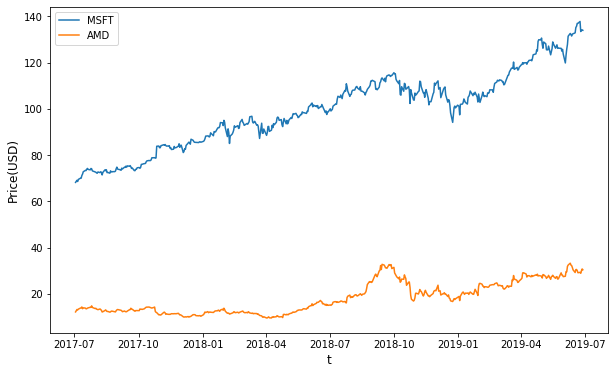

In [6]:
msft = data[i]
amd = data[j]
t = np.arange(len(msft))

plt.figure(figsize=(10, 6))
plt.plot(msft)
plt.plot(amd)
plt.legend([ticker[i], ticker[j]])
plt.ylabel('Price(USD)', fontsize=12)
plt.xlabel('t', fontsize=12)

### Step 3: Contructing our time series data

**(1) 1st-order differencing**  
  
Our goal is to model the spread in daily price change of the two stocks, and we also expect     that the upward trends in both stocks can be removed through this process.

In [7]:
dmsft = msft.diff().dropna()
damd = amd.diff().dropna()

**(2) X: daily price chg. MSFT $-$ daily price chg. AMD** 

In [8]:
pf = dmsft - damd
print(pf.shape)
print(pf.head(5))
print(pf.tail(5))

(500,)
Date
2017-07-05   -0.129996
2017-07-06   -0.340003
2017-07-07    0.550000
2017-07-10    0.070004
2017-07-11   -0.070005
Name: Close, dtype: float64
Date
2019-06-24    0.649998
2019-06-25   -3.950006
2019-06-26   -0.559999
2019-06-27   -0.599998
2019-06-28    0.180012
Name: Close, dtype: float64


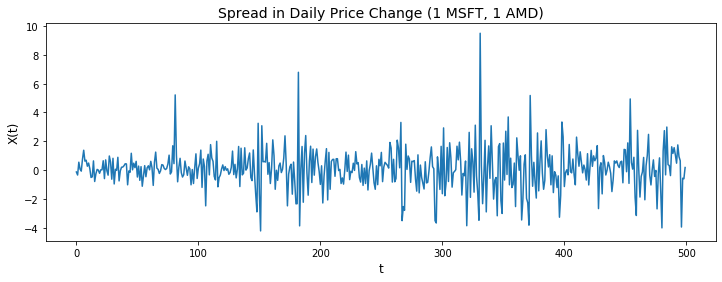

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(pf)), pf);
plt.title("Spread in Daily Price Change (1 MSFT, 1 AMD)", fontsize=14)
plt.xlabel('t', fontsize=12)
plt.ylabel('X(t)', fontsize=12)
plt.show()

**X(t)** =  $\nabla_{t,~t-1}$ MSTF(USD) $-$ $ \nabla_{t,~t-1}$ AMD(USD)
  
**t** = 0, 1, ... , 501 (2018-07-05, 2018-07-06, ... ,2019-06-28)  


### Step 4: Checking stationarity of our data

Even though the graph looks like white noise, there might be implicit trend, cycle, or seasonality.

- **Unit Root Test (Augmented Dickey Fuller test)**  
  
$H_0$: unit root is present (non-stationary)    
$H_1$: $H_0$ is not true (stationary)

In [10]:
def adf_test(pf):
    result = adfuller(pf, autolag='AIC')
    print(f'ADF Statistic: {result[0]}'+"\n")
    print(f'p-value: {result[1]}'+"\n")
    for key, value in result[4].items():
        print("alpha="+f' {key}, {value}')
        if abs(result[0]) > abs(value):
            print("Reject Null Hypothesis: the data is likely to be stationary\n")
    mu = np.mean(pf)
    sigsq = np.var(pf, ddof=1)
    print('E[X(t)]=',round(mu, 4))
    print('Var[X(t)]=',round(sigsq, 4))
    
adf_test(pf)

ADF Statistic: -19.664391134292185

p-value: 0.0

alpha= 1%, -3.4435494520411605
Reject Null Hypothesis: the data is likely to be stationary

alpha= 5%, -2.8673612117611267
Reject Null Hypothesis: the data is likely to be stationary

alpha= 10%, -2.5698704830567247
Reject Null Hypothesis: the data is likely to be stationary

E[X(t)]= 0.0951
Var[X(t)]= 2.0785


Based on the ADF test result, our data is stationary at 99% confidence level, with the mean 0.0951.

### Step 5: Model Selection

**(1) Visualizing ACF and PACF plots using python libary**

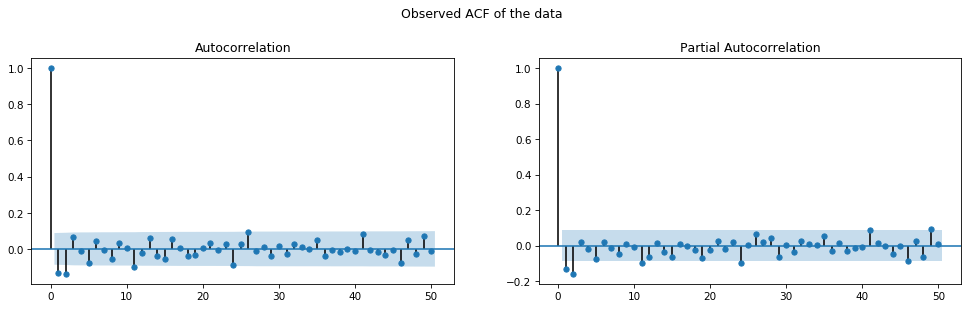

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
fig.suptitle("Observed ACF of the data", y=1.05)
plot_acf(pf, lags=50, ax=axes[0]);
plot_pacf(pf, lags=50, ax=axes[1]);

Based on ACF and PACF plots, autocorrelation of 1 lag and 2 lags seem significant. We will build several ARMA models to confirm this.

**(2) Fit ARMA(p, q)**

In [12]:
model = ARIMA(pf, order=(2,0,1))
result1 = model.fit(disp=0)
print(result1.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  500
Model:                     ARMA(2, 1)   Log Likelihood                -880.892
Method:                       css-mle   S.D. of innovations              1.409
Date:                Mon, 11 May 2020   AIC                           1771.784
Time:                        01:04:52   BIC                           1792.857
Sample:                             0   HQIC                          1780.053
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0955      0.049      1.950      0.051      -0.000       0.191
ar.L1.Close    -0.2864      0.248     -1.156      0.248      -0.772       0.199
ar.L2.Close    -0.1761      0.052     -3.408    

The coefficient of MA(1) term is not statistically significant based on its p-value.

In [13]:
model = ARIMA(pf, order=(2,0,0))
result2 = model.fit(disp=0)
print(result2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  500
Model:                     ARMA(2, 0)   Log Likelihood                -881.017
Method:                       css-mle   S.D. of innovations              1.409
Date:                Mon, 11 May 2020   AIC                           1770.034
Time:                        01:04:52   BIC                           1786.892
Sample:                             0   HQIC                          1776.649
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0955      0.048      1.987      0.047       0.001       0.190
ar.L1.Close    -0.1543      0.044     -3.498      0.000      -0.241      -0.068
ar.L2.Close    -0.1585      0.044     -3.595    

Based on the above results, we can select AR(2) model for significant p-values given 95% confidence level even though the values of the coefficients are rather small. At this point, AR(2) model seems to be the best model. Now we will check the residuals.

### Step 6: Checking residuals

E[Residuals]= -0.0003
Var[Residuals]= 1.9899


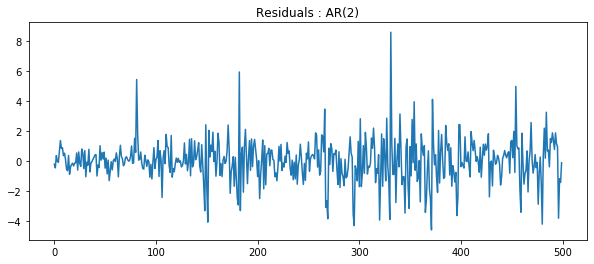

In [14]:
residual_mean = np.mean(result2.resid)
residual_var = np.var(result2.resid, ddof=1)

print('E[Residuals]=', round(residual_mean, 4))
print('Var[Residuals]=', round(residual_var, 4))
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(result2.resid)), result2.resid)
plt.title('Residuals : AR(2)')
plt.show()

**(1) Checking Stationarity of Residuals AR(2)**

In [15]:
adf_test(result2.resid)

ADF Statistic: -22.22473332490456

p-value: 0.0

alpha= 1%, -3.4435228622952065
Reject Null Hypothesis: the data is likely to be stationary

alpha= 5%, -2.867349510566146
Reject Null Hypothesis: the data is likely to be stationary

alpha= 10%, -2.569864247011056
Reject Null Hypothesis: the data is likely to be stationary

E[X(t)]= -0.0003
Var[X(t)]= 1.9899


Based on the ADF test result, the residuals of our AR(2) model are stationary.

**(2) Checking linear independence of Residuals AR(2)**

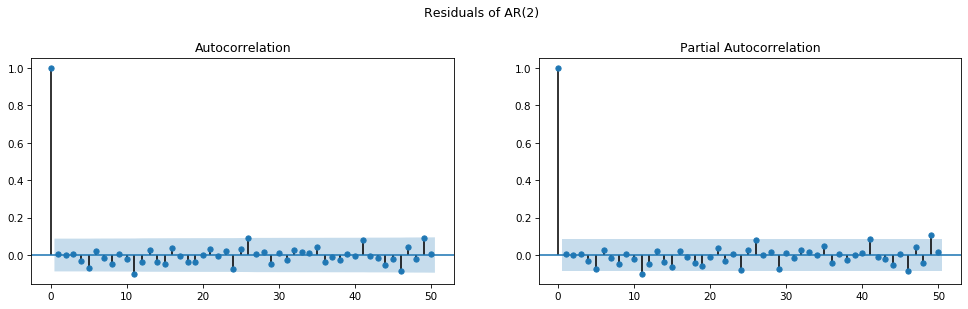

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
fig.suptitle("Residuals of AR(2)", y=1.05)
plot_acf(result2.resid, lags=50, ax=axes[0]);
plot_pacf(result2.resid, lags=50, ax=axes[1]);

The residuals look almost like white noise with the mean very close to 0, but we will verify this with Ljung-Box test

In [17]:
def get_ACF(x, n):
    
    acf = np.ones(n) * 0.001
    #print(acf)
    #print(acf.shape)
    length = len(x)

    for i in range(1, n+1):
        x1 = x[0+i:length]
        var1 = np.var(x1)
        mu = np.mean(x) * np.ones_like(x1)
        x2 = x[0:length-i]
        var2 = np.var(x2)
        cov = np.dot((x1 - mu), (x2 - mu)) / len(x1) 
        acf[i-1] = cov / (np.sqrt(var1) * np.sqrt(var2))
        
    return acf

def Ljung_Box_a90(x, acf, n):
    crt = [2.706, 2.706, 2.706, 4.605, 6.251, 7.779, 9.236, 10.645, 12.017, 13.362]
    Q = np.zeros(n)
    length = len(x)
    dec = []
    for i in range(n):
        Q[i] = length*(length+2)*sum([acf[k]**2 / (length - k - 1) for k in range(i+1)])
        #print(Q[i])
        
        if Q[i] > crt[i]:
            dec.append("Yes (model bad)")
        else:
            dec.append("No (model good)")
                   
    return Q, np.array(dec)

- **Ljung-Box test**  
  
**$H0:$** Data are independently distributed ($\rho_1 =\rho_2 = ... =\rho_{10} = 0$)    
**$H1:$** $H0$ is not True  

Ljung-Box statistic: $Q=n(n+2)\Sigma_{i=1}^k \rho_{i}^2~/~(n-i)$  
Significane level: $\alpha=0.05$ (90% confidence)  
Reject the null hypothesis if $Q>\chi_{1-\alpha, h}$

In [18]:
n = 10
                       
acf2 = get_ACF(result2.resid, n)
Q, conc = Ljung_Box_a90(result2.resid, acf2, n)

df_acf = pd.DataFrame(data={"ACF": acf2, "Q-statistic":Q, "Reject Null?":conc}, index = np.arange(1, n+1))
df_acf.index.name = 'Lag'
print("90% Confidence Level")
df_acf

90% Confidence Level


,ACF,Q-statistic,Reject Null?
Lag,,,
1,0.003107,0.004855,No (model good)
2,-0.000896,0.005260,No (model good)
3,0.006032,0.023634,No (model good)
4,-0.029657,0.468717,No (model good)
5,-0.072357,3.123523,No (model good)
6,0.023719,3.409375,No (model good)
7,-0.014236,3.512551,No (model good)
8,-0.047100,4.644320,No (model good)
9,0.007086,4.669985,No (model good)


The residuals of AR(2) model may not be almost surely zero,  but at 90% confidence level, Null Hypothesis holds true. Therefore, we will assume linear independece of residuals for now. (we chose 90% over 95% in order to reduce the likelihood of type 2 error)

E[Residuals]= -0.0003
Var[Residuals]= 1.9899


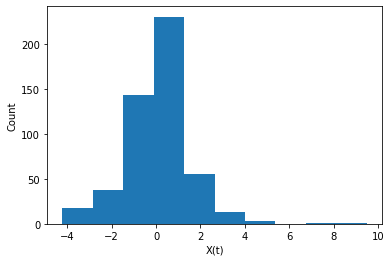

In [19]:
print('E[Residuals]=', round(residual_mean, 4))
print('Var[Residuals]=', round(residual_var, 4))
plt.hist(pf);
plt.xlabel('X(t)');
plt.ylabel('Count');
plt.show()

The residuals look roughly normal with mean 0. We will try chi-square test to check normality

**(3) Testing if -0.0003 is significantly different from 0** 

$H_0: \mu_{\omega}=E[Residual] = 0$  
$H_1:$ $H_0$ is not true  
  
**t-statistic:** $(\overline{Resdual}-0)$ / $\sqrt{1.9899 / 500}$,     
$\overline{Resdual}$ ~ $N(\mu_{\omega} , \sqrt{s_{\omega} / n})$, by **CLT**

In [20]:
tstat = abs((residual_mean - 0) / np.sqrt(residual_var / len(result2.resid)))
print("t-statistic=", tstat)
print("|z value(a=0.01)| =", 2.575)
if tstat > 2.575:
    print("Reject H0")
else:
    print("Do not reject H0")

t-statistic= 0.004272757538945804
|z value(a=0.01)| = 2.575
Do not reject H0


At 99% confidence level, we can assume that the mean of residuals is 0

**(4) Normality test (bucket test)**  

$H_0:$ Residual is Normal  
$H_1:$ $H_0$ is not true

In [21]:
b = 10
df_bucket = pd.DataFrame(data=.1 * np.ones((b, 1)), columns=['exp(p)'])
df_bucket['exp'] = df_bucket['exp(p)'] * len(result2.resid)
temp = np.zeros(b)

for i in range(b):
    temp[i] = sum(((result2.resid - residual_mean) / np.sqrt(residual_var)) <= stats.norm.ppf((i + 1) / b))

obs = np.diff(temp)
obs = np.insert(obs, 0, temp[0])
#print(obs.shape)
df_bucket['obs'] = obs
df_bucket['(obs-exp)^2/exp'] = (df_bucket['exp'] - df_bucket['obs'])**2 / df_bucket['exp']

In [22]:
df_bucket

,exp(p),exp,obs,(obs-exp)^2/exp
0,0.1,50.0,36.0,3.92
1,0.1,50.0,35.0,4.50
2,0.1,50.0,52.0,0.08
3,0.1,50.0,45.0,0.50
4,0.1,50.0,76.0,13.52
5,0.1,50.0,69.0,7.22
6,0.1,50.0,66.0,5.12
7,0.1,50.0,50.0,0.00
8,0.1,50.0,38.0,2.88
9,0.1,50.0,33.0,5.78


In [23]:
chi_stat = sum(df_bucket['(obs-exp)^2/exp'])
print("Chi-squared_obs = ", chi_stat, '( dof=', b-1, ', alpha= 0.01)')
print("critical value =", 23.589)
if chi_stat > 23.589:
    print("Reject H0")
else:
    print("Do not reject H0")

Chi-squared_obs =  43.52 ( dof= 9 , alpha= 0.01)
critical value = 23.589
Reject H0


We don't have sufficient evidence to say that the residual of AR(2) model is normally distributed, but at least we can say it has linearly independent distribution and has a roughly normal shape with mean 0 (random shock). 

$AR(2) :X_t=0.096-0.154 X_{t-1}-0.159 X_{t-2} + \omega_t,~~\omega_t$~$(0, 1.99)$ 

$0.159X_{t-2} + 0.154X_{t-1} + X_t = 0.096 + \omega_t$  
$(1 + 0.154B + 0.159B^2)X_t = 0.096  + \omega_t$ 

$(.159X_{t-2} + 0.154X_{t-1} + X_t)(X_{t+h}) = (0.096 + \omega_t)X_{t+h}$

$0.159\gamma(h-2) + 0.154\gamma(h-1) + \gamma(h) = 0.096 E[X_{t+h}]$

$E[X(t)]= -0.0003$

$0.096*-0.0003 \approx 0 $

$0.159\gamma(h-2) + 0.154\gamma(h-1) + \gamma(h) \approx 0$

$\rho(h) + 0.154\rho(h-1) + 0.159\rho(h-2) = 0$

$\phi(z) = 1 + 0.154z + 0.159z^2$

$z = -0.484 \pm 2.461 i$  
$|z| = 2.508$  
$\theta = -1.765$

$\rho(h) = a|z|^{-h}\cos(h\theta + b) = a2.508^{-h}\cos(-1.765h + b)$

$\rho(0) = 1 = a\cos(b)$

$\rho(1):$  
$\rho(1) + 0.154 + 0.159\rho(1) = 0 $  
$\rho(1) = \frac{-0.154}{1+0.159} \approx -0.133  $  
$-0.133 \approx a2.508^{-1}\cos(-1.765 + b)$

Via Wolfram Alpha:

$a \approx 1.0102$  
$b \approx 3.000$

$\rho(h) \approx -1.0102\times2.508^{-h}\cos(-1.765 h + 3)$

### Step 7: Calculating Model ACF using math to compare with the observed ACF

In [24]:
def analytical_ACF(h):
    return -1.0102*2.50814**-h *np.cos(-1.765986*h + 2.99928)

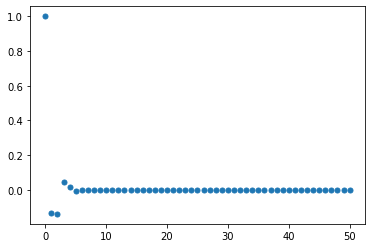

In [25]:
lags = np.arange(0,51)
plt.plot(analytical_ACF(lags), linestyle = "None", marker = ".", markersize = 10)

In [26]:
acf(pf)[0:6], analytical_ACF(np.arange(0,6,1))

(array([ 1.        , -0.13340259, -0.13834284,  0.06310815, -0.0094681 ,
        -0.08061253]),
 array([ 0.99998752, -0.13336931, -0.13833446,  0.04259541,  0.01540234,
        -0.0091532 ]))

### Step 8: AR(2) Model Forecasting

In [27]:
msft_test = pdr.get_data_yahoo("MSFT", start="2019-06-28", end="2019-09-30")['Close'].diff()
amd_test  = pdr.get_data_yahoo("AMD", start="2019-06-28", end="2019-09-30")['Close'].diff()
x_test = msft_test - amd_test
x_test.dropna(inplace=True)
print(x_test.shape)
x_test.head()

(64,)


Date
2019-07-01    0.889986
2019-07-02    0.860010
2019-07-03    0.930004
2019-07-05   -0.710009
2019-07-08   -0.639992
Name: Close, dtype: float64

The rudimentary forecast: We assume we have $X_{t-1}, X_{t-2}$, so we simply plug in for $X_t$.

$X_t=0.096-0.154 X_{t-1}-0.159 X_{t-2} + \omega_t$

In [28]:
def condition_predict_ar(dataseries, observed, no_pred = 1):
    observed = np.insert(observed, 0, dataseries[-1])
    X_t1 = observed[0]
    X_t2 = dataseries[-2]
    output = []
    for i in range(no_pred):
        X_t = 0.096 - 0.154*X_t1 -0.159*X_t2
        output.append(X_t)
        X_t2, X_t1 = observed[i], observed[i+1]
    return output

def plot_prediction(title, predicted, observed):
    plt.figure(figsize=(13, 6))
    plt.plot(predicted)
    plt.plot(observed, alpha=0.6)
    plt.xlabel("t")
    plt.ylabel("X(t)")
    plt.title(title)
    plt.legend(['Predicted', 'Observed'])

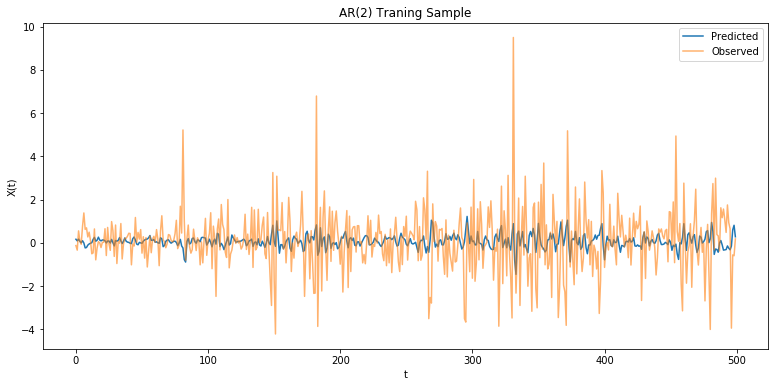

In [29]:
training = condition_predict_ar(pf, pf.values, 500)
plot_prediction('AR(2) Traning Sample', training, pf.values)

In [30]:
def predict_our_model(dataseries, no_pred = 1):
    X_t1 = dataseries[-1]
    X_t2 = dataseries[-2]
    output = []
    for i in range(no_pred):
        X_t = 0.096 - 0.154*X_t1 -0.159*X_t2
        output.append(X_t)
        X_t2, X_t1 = X_t1, X_t
    return output

In [31]:
test = predict_our_model(pf, 64)
print('E[Predicted]', np.mean(test))
print('Var[Predicted]', np.var(test, ddof=1))
print('E[Observed]', np.mean(x_test))
print('Var[Observed]', np.var(x_test, ddof=1))

E[Predicted] 0.0739904603206149
Var[Predicted] 0.0001467532597349429
E[Observed] 0.1007811427116394
Var[Observed] 1.7205944844531744


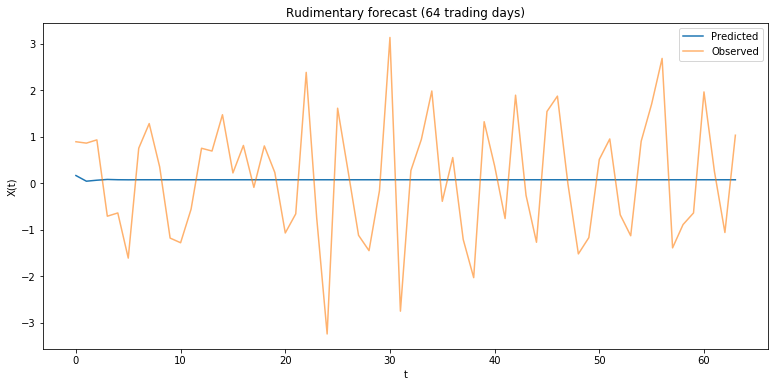

In [32]:
plot_prediction("Rudimentary forecast (64 trading days)", test, x_test.values)

Because Random shock has the mean 0 even though we don't know exactly its distribution, The expected values (Predicted) of 64-day window converges to zero quickly. The reason is that we have all parameters close to zero and so the effect of parameters quickly vanished by the series of multiplication (similiar to the vanishing gradient problem in neural network).

Though, to be fair, the spread does appear to be mean reverting for the test period.

In [33]:
test1 = condition_predict_ar(pf, x_test.values, 64)
print('E[Predicted]', np.mean(test1))
print('Var[Predicted]', np.var(test1, ddof=1))
print('E[Observed]', np.mean(x_test))
print('Var[Observed]', np.var(x_test, ddof=1))

E[Predicted] 0.06746967858076096
Var[Predicted] 0.07994590890410977
E[Observed] 0.1007811427116394
Var[Observed] 1.7205944844531744


- **Next-day Forecasting:** $E[X_t~|X_{t-1},X_{t-2}]$

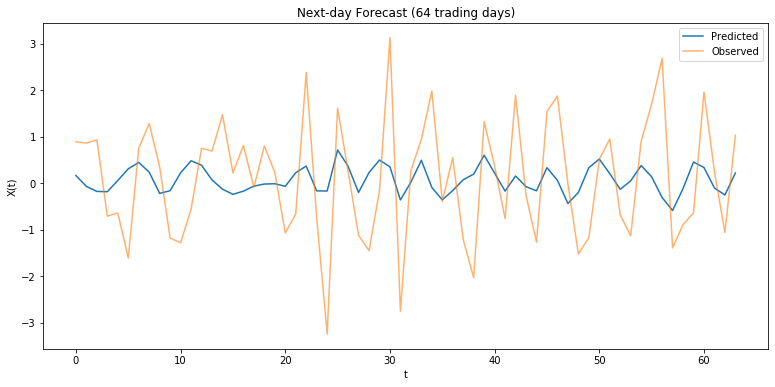

In [34]:
plot_prediction("Next-day Forecast (64 trading days)", test1, x_test.values)

In [35]:
pred_sign = [test1[i] > 0 for i in range(len(test1))]
observed_sign = [x_test.values[i] > 0 for i in range(len(x_test.values))]
accuracy = sum(pred_sign[i] == observed_sign) / len(test1)
print('Accuracy score (+/- classification)=', accuracy)

Accuracy score (+/- classification)= 0.46875


It seems to capture the movement a little better, but it is hard to say whether our AR(2) model has a good fit. We calculated accuracy score based on whether our model predicts correct signs (positive or negative), and the result shows that the model is correct for only 46.88 % of 64 trading days. Even though the chosen pair of stocks has a positive correlation, one stock might be more volatile than the other from time to time. ARMA model doesn't take volatility clustering into account.  

In [136]:
test1_a = np.array(test1)
pred_move = test1_a[1:] > test1_a[:-1]
observed_move = x_test.values[1:] > x_test.values[:-1]
accuracy = sum(pred_move == observed_move) / len(pred_move)
print('Accuracy score (+/- classification)=', accuracy)

Accuracy score (+/- classification)= 0.6666666666666666


However, if we calculate an accuracy score based on the predicted change of the size of the spread, we get a slightly better accuracy of 66.67%. It is hard to say how useful this metric is, as a predictor that lets you know that it the spread will continue to grow, but at a slower rate is not comforting if you're already losing money.

### Step 8: Fitting MA(q) model for comparison

MA.4 term is not significant based on 95% confidence level. We will try to fit MA(3) model.

In [36]:
model = ARIMA(pf, order=(0,0,3))
result3 = model.fit(disp=0)
print(result3.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  500
Model:                     ARMA(0, 3)   Log Likelihood                -881.099
Method:                       css-mle   S.D. of innovations              1.409
Date:                Mon, 11 May 2020   AIC                           1772.197
Time:                        01:04:58   BIC                           1793.270
Sample:                             0   HQIC                          1780.466
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0956      0.047      2.024      0.043       0.003       0.188
ma.L1.Close    -0.1513      0.044     -3.404      0.001      -0.238      -0.064
ma.L2.Close    -0.1362      0.046     -2.984    

MA.3 term is not significant

In [37]:
model = ARIMA(pf, order=(0,0,2))
result4 = model.fit(disp=0)
print(result4.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  500
Model:                     ARMA(0, 2)   Log Likelihood                -881.446
Method:                       css-mle   S.D. of innovations              1.410
Date:                Mon, 11 May 2020   AIC                           1770.891
Time:                        01:04:58   BIC                           1787.750
Sample:                             0   HQIC                          1777.506
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0959      0.045      2.121      0.034       0.007       0.184
ma.L1.Close    -0.1478      0.045     -3.302      0.001      -0.236      -0.060
ma.L2.Close    -0.1364      0.046     -2.953    

In [38]:
print('E[Residual] =', np.mean(result4.resid))
print('Var[Residual] =', np.var(result4.resid, ddof=1))

E[Residual] = -0.00026608316133084584
Var[Residual] = 1.993277272158909


Referring to the previous hypothesis test for AR(2) model, we can assume that the residual of MA(2) model has zero mean.

$MA(2) : E[X_t]=0.096-0.1478 E[\omega_{t-1}]-0.1364 E[\omega_{t-2}] = 0.096,~~\omega_t$~$(0, 1.99)$ 

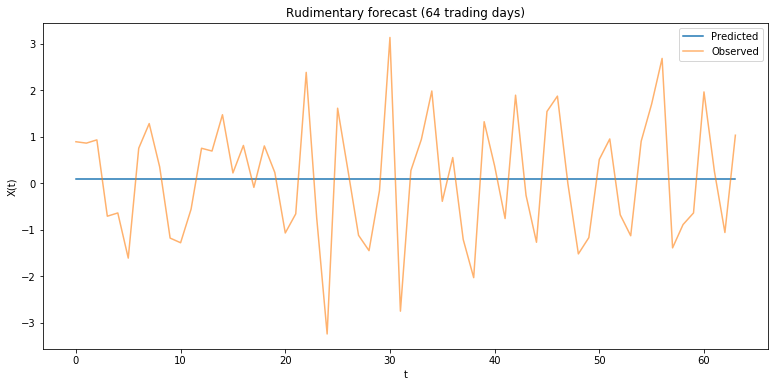

In [39]:
test3 = np.ones_like(test) * 0.096
plot_prediction("Rudimentary forecast (64 trading days)", test3, x_test.values)

Similar to AR(2) model, MA(2) model gives constant predicted value (0.096). In order to develop trading strategies, we need a model that can effectively classify up and down future movement. We see the limitation of ARMA model for stationary time series for our purpose.  


Another way of thinking about this is that a time series approach is unsuited and unnecessary for a mean reverting pairs trading strategy because the underlying assumption of a tradable pair is that the spread follows an Ornstein-Uhlenbeck process, so no insight can be gleaned. 

- **Next-day Forecasting:** $E[X_t~|\omega_{t-1},\omega_{t-2}]$

In [40]:
def condition_predict_ma(dataseries, observed, no_pred = 1):
    observed = np.insert(observed, 0, dataseries[-1])
    X_t1 = observed[0]
    X_t2 = dataseries[-2]
    output = []
    for i in range(no_pred):
        X_t = 0.096 - 0.1478*X_t1 - 0.1364*X_t2
        output.append(X_t)
        X_t2, X_t1 = observed[i], observed[i+1]
    return output

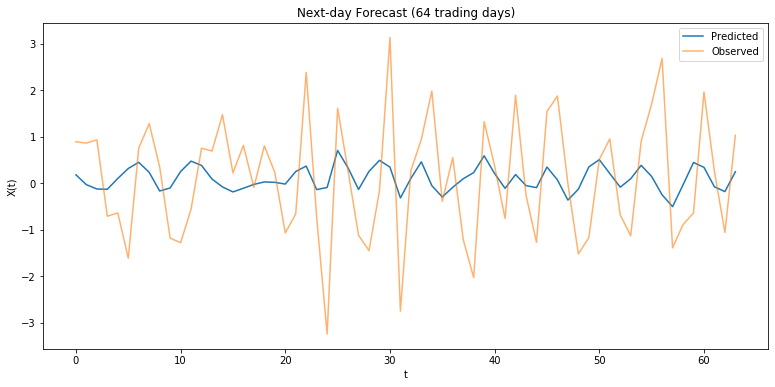

In [41]:
test4 = condition_predict_ma(np.subtract(pf, 0.096), np.subtract(x_test.values, 0.096), 64) 
plot_prediction("Next-day Forecast (64 trading days)", test4, x_test.values)

In [42]:
pred_sign = [test4[i] > 0 for i in range(len(test1))]
observed_sign = [x_test.values[i] > 0 for i in range(len(x_test.values))]
accuracy = sum(pred_sign[i] == observed_sign) / len(test4)
print('Accuracy score (+/- classification)=', accuracy)

Accuracy score (+/- classification)= 0.46875


Based on the above plots and accuracy score for sign classification, MA(2) model doesn't peform any better but yields the same result as AR(2) model.  

## Does an ARCH/GARCH Model provide more meaningful results?

We do not expect an ARCH/GARCH fit to provide much meaningful improvement because the Ljung-Box Test, as done earlier, suggests that there is no serial correlation. However, it is still worth trying.

We also perform Engel's Test for Autoregressive Conditional Heteroscedasticity on the residuals of the AR(2) Model.

In [43]:
print(het_arch(result2.resid))

(34.0788508935506, 0.012316063334654721, 1.9570046592141657, 0.010821058973221116)


As the p-values are small, it may be possible that the alternative hypothesis, that meaningful autocorrelation exists in the squared residuals, is true.

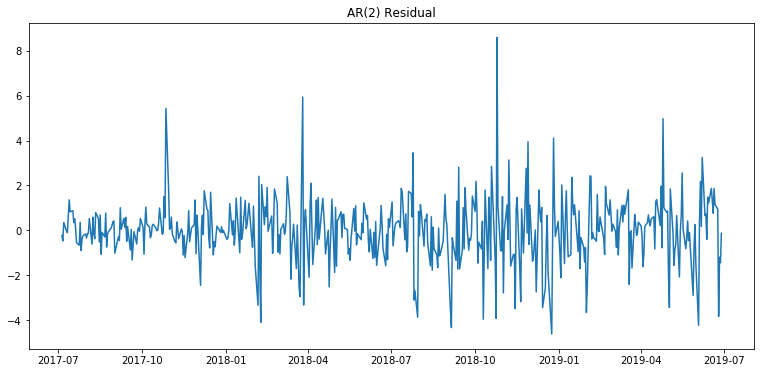

In [102]:
plt.figure(figsize=(13, 6))
plt.title("AR(2) Residual")
plt.plot(result2.resid)

We examine the level of autocorrelation for the squared magnitude of the spread.

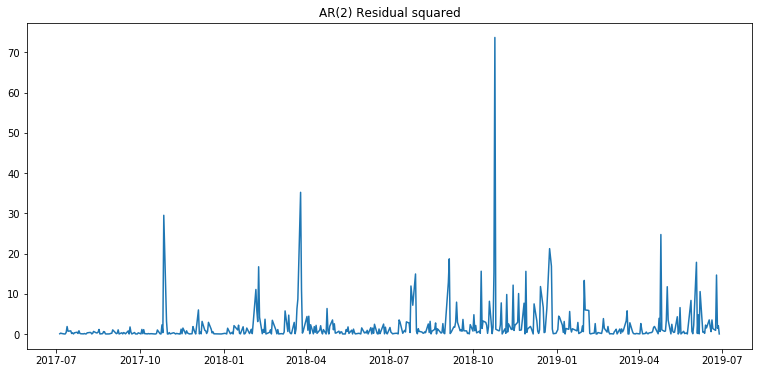

In [103]:
plt.figure(figsize=(13, 6))
plt.title("AR(2) Residual squared")
plt.plot(result2.resid**2)

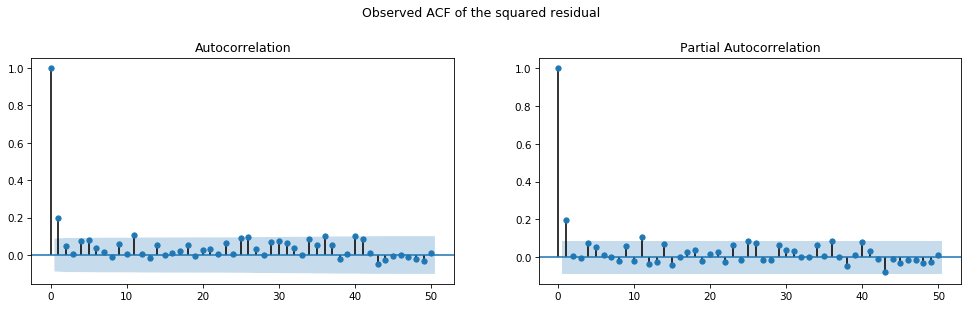

In [104]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
fig.suptitle("Observed ACF of the squared residual", y=1.05)
plot_acf(result2.resid**2, lags=50, ax=axes[0]);
plot_pacf(result2.resid**2, lags=50, ax=axes[1]);

Just from observation, the squared residual of the AR(2) model has a weak 1-period lag autocorrelation.

Our starting point will be p = 2, as that is the AR model we used that seemed most effective. We choose the Standardized Skew Student's t distribution because we expect skewed residuals.

In [88]:
archm = arch_model(result2.resid, p=2, o= 0,q=0, dist = 'skewt')
resarch = archm.fit(update_freq = 5);

print(resarch.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: 826.5946604087011
Iteration:     10,   Func. Count:     92,   Neg. LLF: 822.9255120064213
Iteration:     15,   Func. Count:    132,   Neg. LLF: 822.7879647583993
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 822.7878827128668
            Iterations: 17
            Function evaluations: 148
            Gradient evaluations: 17
                            Constant Mean - ARCH Model Results                           
Dep. Variable:                              None   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                  ARCH   Log-Likelihood:               -822.788
Distribution:      Standardized Skew Student's t   AIC:                           1657.58
Method:                       Maximum Likelihood   BIC:                           1682.86
                                 

In [141]:
archm = arch_model(result2.resid, p=1, o= 0,q=0, dist = 'normal')
resarch = archm.fit(update_freq = 5);

print(resarch.summary())

Iteration:      5,   Func. Count:     33,   Neg. LLF: 850.7283288693158
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 850.4486939909359
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -850.449
Distribution:                  Normal   AIC:                           1706.90
Method:            Maximum Likelihood   BIC:                           1719.54
                                        No. Observations:                  500
Date:                Mon, May 11 2020   Df Residuals:                      497
Time:                        03:07:31   Df Model:                            3
         

Since the second lag term is not significant at the 10% level, we try again but with only 1 lag term.

The ARCH model suggests that the mean of our residuals is essentially 0, as expected, and that our volatility is approximately given by the process:

$$\sigma^2_t \approx 1.3 + 0.40\epsilon_{t-1}^2$$   

and the residual is described by:

$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t Z_t$$

While the AIC of the 2-lag model is slightly better than that of the second model, and slight changes in AIC have major implications in preserved information, the second lag term is not adequately statistically significant. We procede using the 1-lag model.

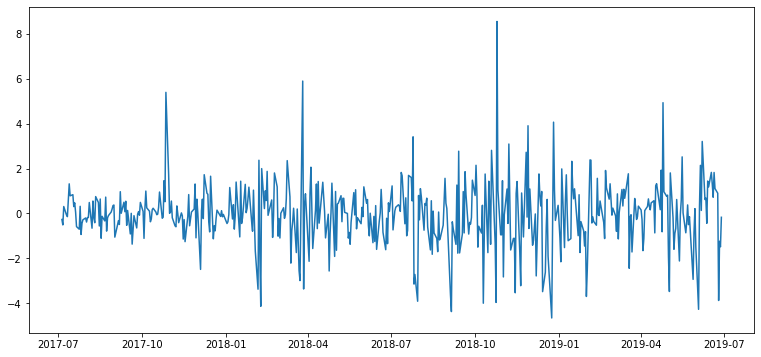

In [142]:
plt.figure(figsize=(13, 6))
plt.plot(resarch.resid)

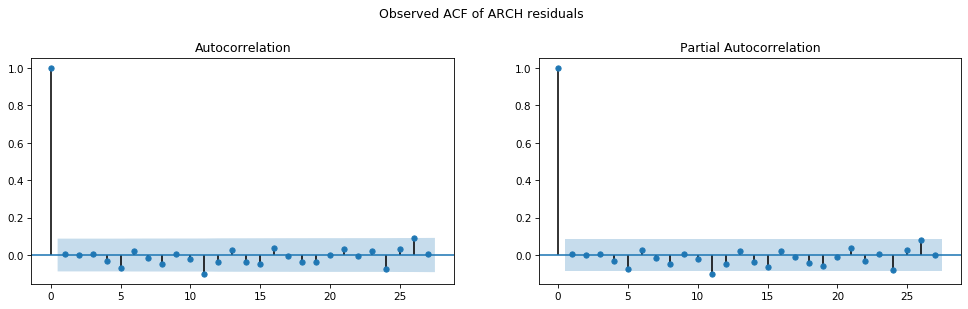

In [143]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
fig.suptitle("Observed ACF of ARCH residuals", y=1.05)
plot_acf(resarch.resid, ax = axes[0]); plot_pacf(resarch.resid, ax = axes[1]);

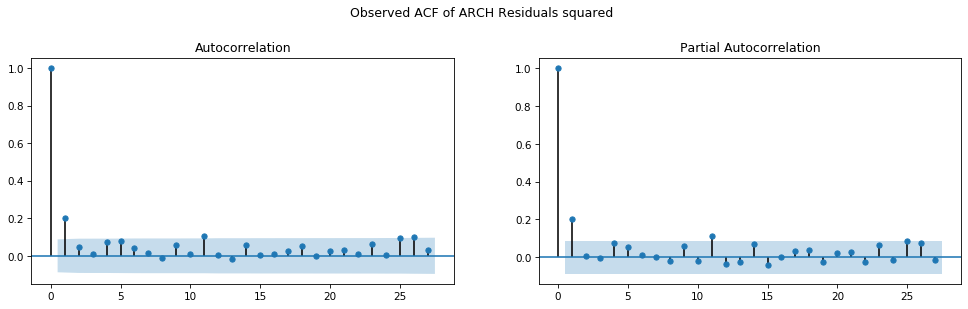

In [144]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
fig.suptitle("Observed ACF of ARCH Residuals squared", y=1.05)
plot_acf(resarch.resid**2, ax = axes[0]); plot_pacf(resarch.resid**2, ax = axes[1]);

However, the residual of the ARCH Model does not eliminate the autocorrelation in the squared residual. Thus, the combination of an AR(2) Model and an ARCH(1) model is not adequate to fully explain this constructed signal from a time series perspective.